Question1 Part A

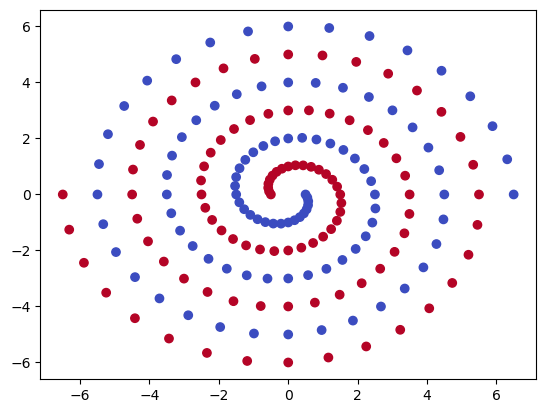

In [1]:
#Add Imports for packages
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

# Setup seed so results consistent Note: it doesn't need to be seeded to work jsut allows you to replicate exact results 
torch.manual_seed(42)

#Import 2 Spiral Dataset 
data = pd.read_csv('datasets/spiralsdataset.csv', header=None, names=['x1', 'x2', 'y'])

# Split the dataset into features and labels
X = data[['x1', 'x2']].to_numpy()
y = data['y'].to_numpy()


# Plot the dataset
plt.scatter(X[:,0], X[:,1], c=y, cmap='coolwarm')
plt.show()

y = np.eye(2)[y]

#Declare empty Net class so that the training process can be defined before the specifics of each neural network are made such as the number of hidden layers and activation functions used
class Net(nn.Module):
    def __init__(self) -> None:
        super().__init__()


In [2]:
##Function For calculating average accuracy
def calculate_accuracy(fold_training_accs,fold_test_accs):

    avg_train_accs, avg_test_accs = 0,0
    print("Training Results")
    for i in range(len(fold_training_accs)):
        print(f"Fold {i+1} Training Accuracy: {fold_training_accs[i]}, Test Accuracy:{fold_test_accs[i]}")
        avg_train_accs = avg_train_accs  + fold_training_accs[i]
        avg_test_accs = avg_test_accs + fold_test_accs[i]
    avg_train_accs = avg_train_accs/len(fold_training_accs)
    avg_test_accs = avg_test_accs/len(fold_test_accs)
    print()
    print("Testing Results:")
    print(f"Overall Training Accuracy: {avg_train_accs}")
    print()
    print(f"Overall Test Accuracy: {avg_test_accs}")

    return 


def calculate_losses(train_losses,test_losses,num_folds):

    for i in range(num_folds):
        print('Fold {}, Training loss: {:.4f}, Test loss: {:.4f}'
        .format(i+1, train_losses[i], test_losses[i]))

    avg_train_loss = sum(train_losses) / num_folds
    avg_test_loss = sum(test_losses) / num_folds
    print()
    print('Average Training loss: {:.4f}, Average Test loss: {:.4f}'
    .format(avg_train_loss, avg_test_loss))
    print("\n\n")

Now define a function that can be reused with different hyper parameters to evaluate how different hyper parameters impact the Neural Networks effectiveness

In [3]:
#Define the training function that trains the FFNN based on the data and hyper parameters
def train_FFNN(X,y,num_folds,num_epochs,learning_rate,input_size,hidden_size,output_size):

    criterion = nn.BCELoss()
    #Breaks data up into K-folds that are then trained and tested on independently
    kf = KFold(n_splits=num_folds, shuffle= True, random_state= 42)
    # Arrays that store information on models performance
    loss_list = []
    train_losses = []
    test_losses = []
    fold_test_accs = []
    fold_training_accs = []
    grid_predicted_folds = []

    #loops through the training process with the split up data for K Folds
    for fold, (train, test) in enumerate(kf.split(X)):
        net = Net(input_size, hidden_size, output_size)
        optimizer = optim.Adam(net.parameters(), lr=learning_rate)


        print(f"Fold {fold + 1}/{num_folds}")

        # Split the dataset into training and test data
        X_train, X_test = X[train], X[test]
        y_train, y_test = y[train], y[test]

        # Convert the training and test data to PyTorch tensors
        X_train = torch.from_numpy(X_train).type(torch.float32)
        X_test = torch.from_numpy(X_test).type(torch.float32)
        y_train = torch.from_numpy(y_train).type(torch.float32)
        y_test = torch.from_numpy(y_test).type(torch.float32)


         # Train the FFNN
        for epoch in range(num_epochs):
            # Forward pass
            outputs = net(X_train)
            loss = criterion(outputs, y_train)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Save the loss for this epoch
            loss_list.append(loss.item())

        # Save the training and test losses for this fold
        train_losses.append(loss_list[-1])
        test_loss = criterion(net(X_test), y_test)
        test_losses.append(test_loss.item())
        
        with torch.no_grad():
            outputs = net(X_train)
            _, predicted_class = torch.max(outputs.data, 1)
            predicted_class = np.array(predicted_class)
            fold_correct = sum(predicted_class[i] == y_train[i].argmax() for i in range(len(predicted_class)))
            fold_training_accs.append(fold_correct/len(y_train))
        
        #evaluates the test set to determine the accuracy
        with torch.no_grad():
            outputs = net(X_test)
            _, predicted_class = torch.max(outputs.data, 1)
            predicted_class = np.array(predicted_class)
            fold_correct = sum(predicted_class[i] == y_test[i].argmax() for i in range(len(predicted_class)))
            fold_test_accs.append(fold_correct/len(y_test))
    
        x1_min, x1_max = X[:, 0].min()-0.1, X[:, 0].max()+0.1
        x2_min, x2_max = X[:, 1].min()-0.1, X[:, 1].max()+0.1
        xx, yy = torch.meshgrid(torch.linspace(x1_min, x1_max, 100),
                                torch.linspace(x2_min, x2_max, 100))
        X_grid = torch.cat((xx.reshape(-1,1), yy.reshape(-1,1)), dim=1)
        
        # Get the predicted_class class labels for the grid points
        with torch.no_grad():
            grid_outputs = net(X_grid)
            grid_predicted_class = torch.argmax(grid_outputs, dim=1)

        grid_predicted_folds.append(grid_predicted_class)
        # Plot the decision boundary
        plt.contourf(xx, yy, grid_predicted_class.reshape(xx.shape), cmap='coolwarm', alpha=0.5)
        plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test.argmax(axis=1), cmap='coolwarm')
        plt.title('Test Data with Decision Boundary')
        plt.show()
        net = None  
        
    #Calculate the average training and validation loss across all folds
    avg_train_loss = sum(train_losses) / num_folds
    avg_test_loss = sum(test_losses) / num_folds
    print('Average train loss: {:.4f}, Average val loss: {:.4f}'
        .format(avg_train_loss, avg_test_loss))
    
    calculate_losses(train_losses,test_losses,num_folds)
    calculate_accuracy(fold_training_accs,fold_test_accs)

    #Determine the average decision boundary across all 10 folds
    grid_predicted_folds = torch.stack(grid_predicted_folds)
    grid_predictions, _ = torch.mode(grid_predicted_folds, dim=0)    
    plt.contourf(xx, yy, grid_predictions.reshape(xx.shape), cmap='coolwarm', alpha=0.5)
    # plt.scatter(X[:, 0], X[:, 1], c=y.argmax(axis=1), cmap='coolwarm')
    plt.title('Test Data with Decision Boundary')
    plt.show()

In [4]:
# ##FFNN First Attempt
# class Net(nn.Module):
#     def __init__(self, input_size, hidden_size, output_size):
#         super(Net, self).__init__()
#         self.fc1 = nn.Linear(input_size, hidden_size, bias=True)
#         self.fc2 = nn.Linear(hidden_size, hidden_size, bias=True)
#         self.fc3 = nn.Linear(hidden_size, output_size, bias=True)
#         #Define activation functions that can be used
#         self.reluAct = nn.ReLU()
#         self.tanAct = nn.Tanh()
#         self.lReluAct = nn.LeakyReLU()
#         self.sigmoidAct = nn.Sigmoid()

#     def forward(self, x):
#         x = self.fc1(x)
#         x = self.reluAct(x)
#         x = self.fc2(x)
#         x = self.reluAct(x)
#         x = self.fc3(x)
#         x = nn.Softmax(dim=1)(x)
#         return x
    

# # Changed these for initial 2 hidden layer FFNN the hyperparameters
# input_size = 2
# hidden_size = 16
# output_size = 2
# learning_rate = 0.02
# num_epochs = 1000
# num_folds = 10

# # Create the FFNN 
# train_FFNN(X,y,num_folds,num_epochs,learning_rate,input_size,hidden_size,output_size)

Fold 1/10


c:\Users\Sebastian Hadley\anaconda3\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


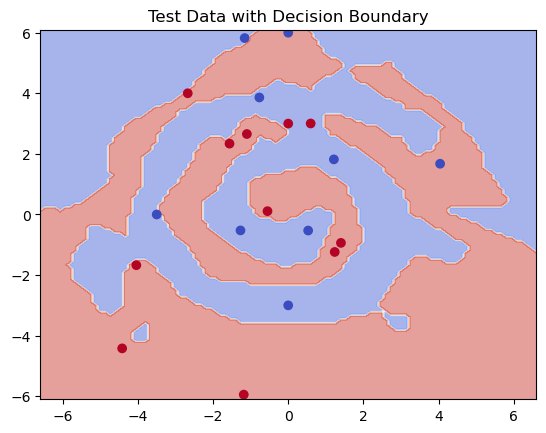

Fold 2/10


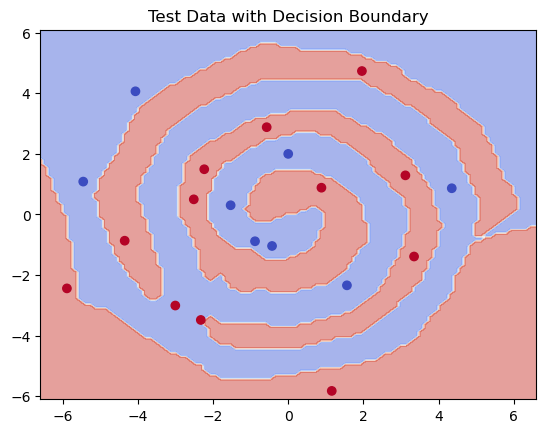

Fold 3/10


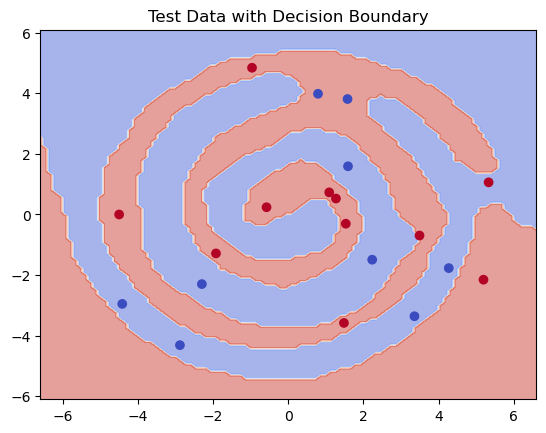

Fold 4/10


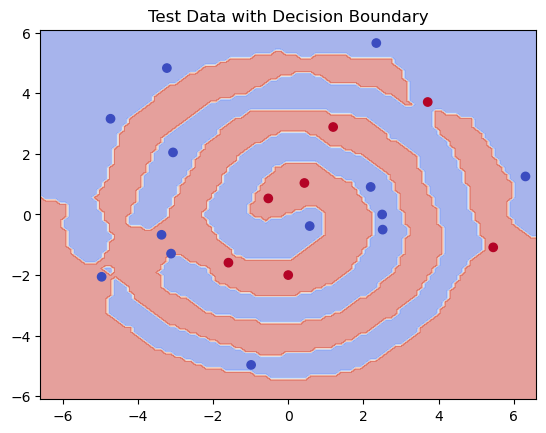

Fold 5/10


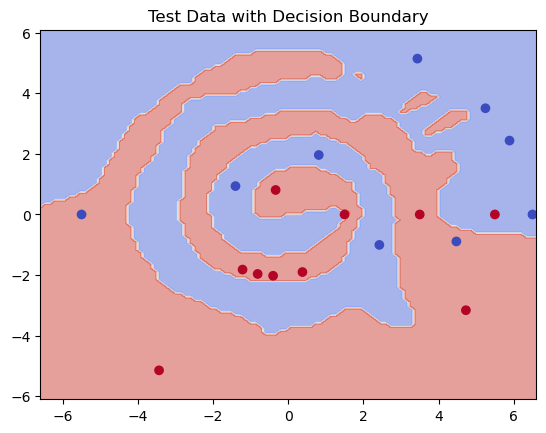

Fold 6/10


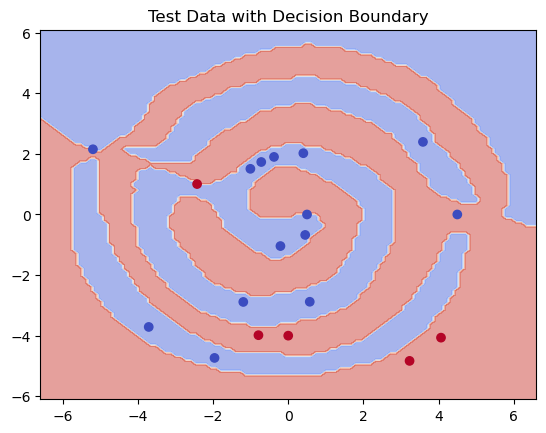

Fold 7/10


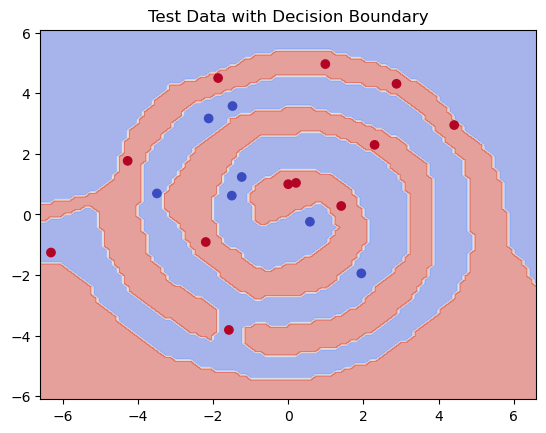

Fold 8/10


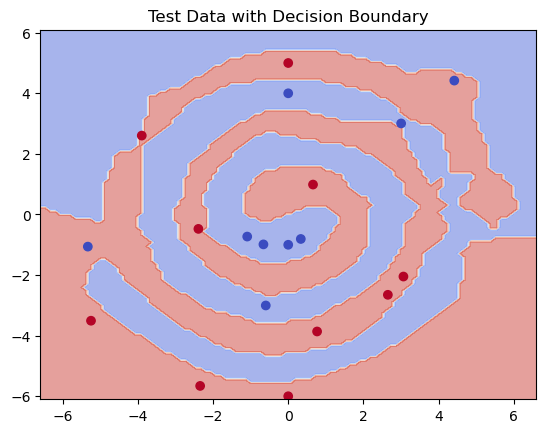

Fold 9/10


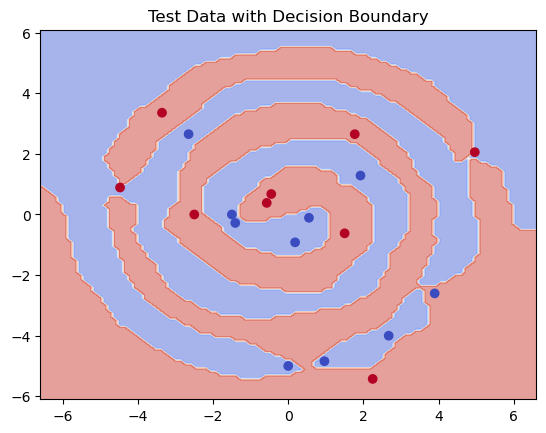

Fold 10/10


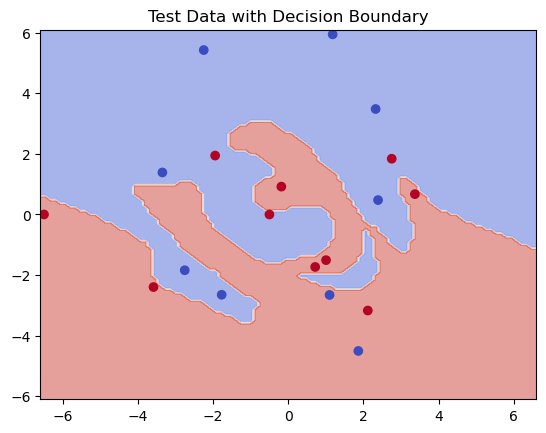

Average train loss: 0.1137, Average val loss: 1.0590
Fold 1, Training loss: 0.2225, Test loss: 0.6942
Fold 2, Training loss: 0.0001, Test loss: 0.9207
Fold 3, Training loss: 0.0000, Test loss: 3.8217
Fold 4, Training loss: 0.0001, Test loss: 1.2114
Fold 5, Training loss: 0.3292, Test loss: 0.5046
Fold 6, Training loss: 0.0010, Test loss: 0.6910
Fold 7, Training loss: 0.0000, Test loss: 0.5967
Fold 8, Training loss: 0.0001, Test loss: 1.0532
Fold 9, Training loss: 0.0000, Test loss: 0.4467
Fold 10, Training loss: 0.5834, Test loss: 0.6502

Average Training loss: 0.1137, Average Test loss: 1.0590



Training Results
Fold 1 Training Accuracy: 0.8908045887947083, Test Accuracy:0.800000011920929
Fold 2 Training Accuracy: 1.0, Test Accuracy:0.8999999761581421
Fold 3 Training Accuracy: 1.0, Test Accuracy:0.8500000238418579
Fold 4 Training Accuracy: 1.0, Test Accuracy:0.800000011920929
Fold 5 Training Accuracy: 0.8857142925262451, Test Accuracy:0.7894737124443054
Fold 6 Training Accuracy: 1.0,

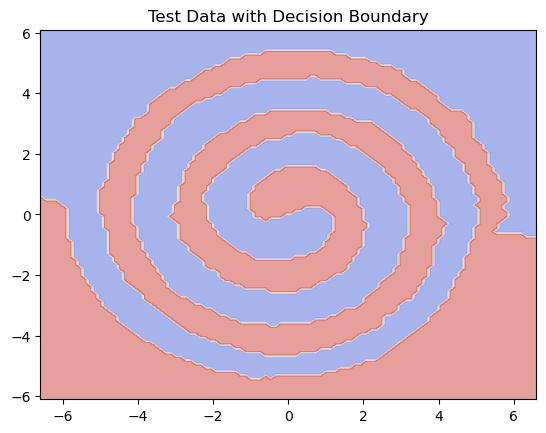

In [5]:

##FFNN Successful Attempt
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size, bias=True)
        self.fc2 = nn.Linear(hidden_size, hidden_size, bias=True)
        self.fc3 = nn.Linear(hidden_size, output_size, bias=True)
        self.reluAct = nn.ReLU()
        self.tanAct = nn.Tanh()
        self.lReluAct = nn.LeakyReLU()
        self.sigmoidAct = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.reluAct(x)
        x = self.fc2(x)
        x = self.lReluAct(x)
        x = self.fc2(x)
        x = self.lReluAct(x)
        x = self.fc2(x)
        x = self.lReluAct(x)
        x = self.fc2(x)
        x = self.tanAct(x)
        x = self.fc3(x)
        x = nn.Softmax(dim=1)(x)
        return x
    

# Set the hyperparameters
input_size = 2
hidden_size = 64
output_size = 2
learning_rate = 0.01
num_epochs = 1000
num_folds = 10

# Create the FFNN 
train_FFNN(X,y,num_folds,num_epochs,learning_rate,input_size,hidden_size,output_size)
